In [1]:
import os 
import re
import glob 
import math
import pickle
import joblib

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from IPython.display import display
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import scipy
from scipy import stats,interpolate
from scipy.stats import skew,kurtosis,describe,variation,shapiro,levene,f_oneway
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

sns.set(font_scale=1.0)
#import matplotlib.pyplot as plt
#plt.rcParams['font.family'] ='Malgun Gothic'
#plt.rcParams['axes.unicode_minus'] =False

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats
    
def mse(y,pred):
    return mean_squared_error(y,pred)
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))
def MAPE(y,pred):
    return np.mean(np.abs((y-pred)/y)*100)    
def SMAPE(y, pred):
    return (np.mean((np.abs(y-pred))/(np.abs(y) + np.abs(pred))))*100
def evaluate_regr(y,pred): # 종합 평가지표 
    mse_val = mse(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    mape_val = np.mean(np.abs((y-pred)/y)*100)
    smape_val = 100 / len(y) * np.sum(np.abs(pred - y) / (np.abs(y) + np.abs(pred)))
    print("MSE:{0:4F},RMSE:{1:4f},MAE:{2:4F},MAPE:{3:4F},SMAPE:{4:4F}".format(mse_val,rmse_val,mae_val,mape_val,smape_val))

#### 1.) 2023 & 2024 전체 CSV 파일 업로드 

In [3]:
# 1.) 2023 
df2023_1 = pd.read_csv('2023/01_원당.csv').drop(['TimeStamp'],axis=1)              # 1.) 원당
df2023_2 = pd.read_csv('2023/02_세당공정.csv').drop(['TimeStamp'],axis=1)          # 2.) 세당
df2023_3 = pd.read_csv('2023/04_포충공정.csv').drop(['TimeStamp'],axis=1)          # 3.) 포충
df2023_4 = pd.read_csv('2023/05_1차 여과공정.csv').drop(['TimeStamp'],axis=1)      # 4.) 1차 여과
df2023_5 = pd.read_csv('2023/06_2차 정제공정.csv').drop(['TimeStamp'],axis=1)      # 5.) 2차 정제
df2023_6 = pd.read_csv('2023/07_2,3차 여과공정.csv').drop(['TimeStamp'],axis=1)    # 6.) 2,3차 여과
df2023_7 = pd.read_csv('2023/08_3차 정제공정.csv').drop(['TimeStamp'],axis=1)      # 7.) 3차 정제
df2023_8 = pd.read_csv('2023/09_이중효용관.csv').drop(['TimeStamp','Root.정당.농축공정.농축관 1호.08FC0401_PV'],axis=1)    # 8.) 이중효용관
df2023_9 = pd.read_csv('2023/10_MVR.csv')                                      # 9.) MVR
df2023_9['TimeStamp'] = pd.to_datetime(df2023_9['TimeStamp'])
df2023_9['Date'] = df2023_9['TimeStamp'].dt.date
print('2023년',df2023_1.shape, df2023_2.shape, df2023_3.shape, df2023_4.shape, df2023_5.shape, df2023_6.shape, df2023_7.shape, df2023_8.shape, df2023_9.shape)

###############################################################################################################################

# 2.) 2024
df2024_1 = pd.read_csv('2024/01_원당.csv').drop(['TimeStamp'],axis=1)       # 1.) 원당
df2024_2 = pd.read_csv('2024/02_세당.csv').drop(['TimeStamp'],axis=1)       # 2.) 세당
df2024_3 = pd.read_csv('2024/03_포충.csv').drop(['TimeStamp'],axis=1)       # 3.) 포충
df2024_4 = pd.read_csv('2024/04_1차여과.csv').drop(['TimeStamp'],axis=1)    # 4.) 1차 여과
df2024_5 = pd.read_csv('2024/05_2차정제.csv').drop(['TimeStamp'],axis=1)    # 5.) 2차 정제
df2024_6 = pd.read_csv('2024/06_2,3차여과.csv').drop(['TimeStamp'],axis=1)  # 6.) 2,3차 여과
df2024_7 = pd.read_csv('2024/07_3차정제.csv').drop(['TimeStamp'],axis=1)    # 7.) 3차 정제
df2024_8 = pd.read_csv('2024/08_이중효용관.csv').drop(['TimeStamp'],axis=1) # 8.) 이중효용관
df2024_9 = pd.read_csv('2024/09_MVR.csv')                                   # 9.) MVR   
df2024_9['TimeStamp'] = pd.to_datetime(df2024_9['TimeStamp'])
df2024_9['Date'] = df2024_9['TimeStamp'].dt.date
print('2024년',df2024_1.shape, df2024_2.shape, df2024_3.shape, df2024_4.shape, df2024_5.shape, df2024_6.shape, df2024_7.shape, df2024_8.shape, df2024_9.shape)     

###############################################################################################################################

# 3.) 2024 추가
df2024add_1 = pd.read_csv('2024_추가/01_원당.csv').drop(['TimeStamp'],axis=1)       # 1.) 원당 
df2024add_2 = pd.read_csv('2024_추가/02_세당.csv').drop(['TimeStamp'],axis=1)       # 2.) 세당
df2024add_3 = pd.read_csv('2024_추가/03_포충.csv').drop(['TimeStamp'],axis=1)       # 3.) 포충
df2024add_4 = pd.read_csv('2024_추가/04_1차여과.csv').drop(['TimeStamp'],axis=1)    # 4.) 1차 여과
df2024add_5 = pd.read_csv('2024_추가/05_2차정제.csv').drop(['TimeStamp'],axis=1)    # 5.) 2차 정제
df2024add_6 = pd.read_csv('2024_추가/06_2,3차여과.csv').drop(['TimeStamp'],axis=1)  # 6.) 2,3차 여과
df2024add_7 = pd.read_csv('2024_추가/07_3차정제.csv').drop(['TimeStamp'],axis=1)    # 7.) 3차 정제
df2024add_8 = pd.read_csv('2024_추가/08_이중효용관.csv').drop(['TimeStamp'],axis=1) # 8.) 이중효용관
df2024add_9 = pd.read_csv('2024_추가/09_MVR.csv')                                   # 9.) MVR   
df2024add_9['TimeStamp'] = pd.to_datetime(df2024add_9['TimeStamp'])
df2024add_9['Date'] = df2024add_9['TimeStamp'].dt.date
print('2024년 7~9월',df2024add_1.shape, df2024add_2.shape, df2024add_3.shape, df2024add_4.shape, df2024add_5.shape, df2024add_6.shape, df2024add_7.shape, df2024add_8.shape, df2024add_9.shape) 

2023년 (52417, 27) (52417, 6) (52417, 12) (52417, 16) (52417, 22) (52417, 12) (52417, 24) (52417, 8) (52417, 14)
2024년 (26207, 27) (26207, 6) (26207, 12) (26207, 16) (26207, 22) (26207, 12) (26207, 24) (26207, 8) (26207, 14)
2024년 7~9월 (13247, 27) (13247, 6) (13247, 12) (13247, 16) (13247, 22) (13247, 12) (13247, 24) (13247, 8) (13247, 14)


In [4]:
# 4.) 1차 변수 제거 
df2023_1 = df2023_1[df2023_1.columns.tolist()[:10]+['탄산포충1탑 온도','탄산포충2탑 온도','탄산포충1탑 CaO','탄산포충2탑 CaO']]
df2023_1.drop(['용당관농도','용당관온도'],axis=1,inplace=True)
df2024_1 = df2024_1[df2024_1.columns.tolist()[:10]+['탄산포충1탑 온도','탄산포충2탑 온도','탄산포충1탑 CaO','탄산포충2탑 CaO']]
df2024_1.drop(['용당관농도','용당관온도'],axis=1,inplace=True)
df2024add_1 = df2024add_1[df2024add_1.columns.tolist()[:10]+['탄산포충1탑 온도','탄산포충2탑 온도','탄산포충1탑 CaO','탄산포충2탑 CaO']]
df2024add_1.drop(['용당관농도','용당관온도'],axis=1,inplace=True)

df_2023 = pd.concat([df2023_1,df2023_2,df2023_3,df2023_4,df2023_5,df2023_6,df2023_7,df2023_8,df2023_9],axis=1)
df_2024 = pd.concat([df2024_1,df2024_2,df2024_3,df2024_4,df2024_5,df2024_6,df2024_7,df2024_8,df2024_9],axis=1)
df_2024add = pd.concat([df2024add_1,df2024add_2,df2024add_3,df2024add_4,df2024add_5,df2024add_6,df2024add_7,df2024add_8,df2024add_9],axis=1)
df_concat = pd.concat([df_2023,df_2024,df_2024add],axis=0).reset_index(drop=True)
print(df_2023.shape, df_2024.shape ,df_2024add.shape,  df_concat.shape)

(52417, 126) (26207, 126) (13247, 126) (91871, 126)


#### 2.) 기간 제거 & 공정 발생 시간차 적용
- ML유량 감소 & 보수기간 --> [23년 9 & 10월], [11/6~11/7] 
- 원당 보수기간 --> [2/6~2/12] & [11/6 & 11/17]

원료입고 ~ 세당공정 : 멜트빈 ~ 분리기 --> 도합 약 19분  

용해공정 : 세당 컨베이어 ~ 스트레나 --> 도합 약 6 분 (용해 공정 데이터 X ) --> 누적 약 25분

포충공정 : (1차 정제공정)포충탑 --> 약 1시간 체류

1차 여과공정 : 1차 여과기 --> 연속 통과

2차 정제공정 : 시스턴    --> 약 2시간 체류 

2,3차 여과공정 : 2차,3차 여과기  --> 연속 통과

3차 정제공정 : 이온교환수지탑  --> 약 1시간 체류

MVR, 이중효용관 :         --> 약 1시간 체류

In [5]:
print(df_concat.TimeStamp.diff().head(4).sum())
print(df_concat.TimeStamp.diff().head(10).sum())
print(df_concat.TimeStamp.diff().head(22).sum())
print(df_concat.TimeStamp.diff().head(28).sum())
print(df_concat.TimeStamp.diff().head(34).sum())


cols_stage1 = df2024_1.columns.tolist()
cols_stage2 = df2024_2.columns.tolist()
cols_stage3 = df2024_3.columns.tolist()
cols_stage4 = df2024_4.columns.tolist()
cols_stage5 = df2024_5.columns.tolist()
cols_stage6 = df2024_6.columns.tolist()
cols_stage7 = df2024_7.columns.tolist()
cols_stage8 = df2024_8.columns.tolist()
cols_stage9 = df2024_9.columns.tolist()


#### -->  최근데이터 기준 정렬
df1 = df_concat[cols_stage1].shift(34)
df2 = df_concat[cols_stage2].shift(30)             
df3 = df_concat[cols_stage3].shift(24)          
df4 = df_concat[cols_stage4].shift(24)                    
df5 = df_concat[cols_stage5].shift(12)          
df6 = df_concat[cols_stage6].shift(12)                  
df7 = df_concat[cols_stage7].shift(6)          
df8 = df_concat[cols_stage8]          
df9 = df_concat[cols_stage9]    

0 days 00:30:00
0 days 01:30:00
0 days 03:30:00
0 days 04:30:00
0 days 05:30:00


In [7]:
df_FL = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9],axis=1).reset_index(drop=True)
df_FL = df_FL.dropna().reset_index(drop=True) 

####  ML유량 감소/보수기간 & 원당 보수기간 전체 제거 
df_FL = df_FL[(df_FL['Date'] < datetime.date(2023, 2, 6)) | (df_FL['Date'] > datetime.date(2023, 2, 12))]
df_FL = df_FL[(df_FL['Date']< datetime.date(2023, 9, 1)) | (df_FL['Date']> datetime.date(2023, 10, 31))]
df_FL = df_FL[(df_FL['Date'] < datetime.date(2023, 11, 6)) | (df_FL['Date'] > datetime.date(2023, 11, 17))]
df_FL = df_FL[(df_FL['Date'] < datetime.date(2024, 3, 11)) | (df_FL['Date'] > datetime.date(2024, 3, 16))]

####  행 단위 결측 제거
df_FL = df_FL.dropna().reset_index(drop=True) 
df_FL.shape

(72938, 126)

#### 3.) Target별 데이터 분할 
- ML은 Y값 먼저 10분뒤로 이동
- DL은 전처리 과정에서 자동으로 이동 

In [8]:
def split_dataset(FL,method):
    
    df_FL_Final = FL.drop(['TimeStamp','Date'],axis=1)
    df_FL_Final = df_FL_Final[(df_FL_Final['Root.정당.MVR 공정.농축관2탑.EV_02_FL_BRIX']>=60) & (df_FL_Final['Root.정당.MVR 공정.농축관2탑.EV_02_FL_BRIX']<=80)].reset_index(drop=True)
    
    #### 추가 조건 
    df_FL_Final = df_FL_Final.loc[:,~df_FL_Final.columns.str.contains('시스턴|수지|SF|RF')]
    df_FL_Final.drop(['포충1탑 석회유 유량','포충2탑 석회유 유량'],axis=1,inplace=True)
    
    df_FL_Final = df_FL_Final.drop(['Root.정당.MVR 공정.농축관2탑.EV_02_FL_FLOW','Root.정당.MVR 공정.농축관2탑.EV_02_LEVEL',
                  'Root.정당.MVR 공정.농축관2탑.EV_02_LIQUEFIED_OUT_TEMP',
                  'Root.정당.MVR 공정.농축관2탑.EV_02_MVR02_VAPOR_TEMP'],axis=1)
    
    df_FL_Final = df_FL_Final.drop(['포충3탑 PH','포충3탑 당액온도','석회비'],axis=1)
    df_FL_Final = df_FL_Final.drop(['탄산포충1탑 온도','탄산포충2탑 온도','탄산포충1탑 CaO','탄산포충2탑 CaO'],axis=1)
    
    if method =='ml':
        target = df_FL_Final['Root.정당.MVR 공정.농축관2탑.EV_02_FL_BRIX'].shift(-1)
        df_FL_Final = df_FL_Final.drop(['Root.정당.MVR 공정.농축관2탑.EV_02_FL_BRIX'],axis=1)
        df_FL_Final = pd.concat([df_FL_Final,target],axis=1)
        df_FL_Final = df_FL_Final.dropna().reset_index(drop=True)
    else:
        pass
    return df_FL_Final

In [9]:
FL = df_FL
method = 'ml'
df_FL_Final = split_dataset(FL,method)
df_FL_Final.shape

(71321, 37)

In [10]:
df_FL_Final.columns = ['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE',                  
 'MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','MAGMA_MINGLER_TEMP_value','CARORIFIER_S/T_TEMP_value',
 'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value','CO2_GAS_PRESS_value',
'SATURATOR1_ML_SUPPLY_F_PV_value','SATURATOR1_PH_PV_value',
 'SATURATOR2_ML_SUPPLY_F_PV_value','SATURATOR2_PH_PV_value','FL_TK_BX_PV_value','FL_TK_P/P_F_value','EVA1_S/T_F_value',
 '08BC0103_PV_value','EVA1_PRESS_value','EVA_VACUMM_V/V_PV_value','EVA2_LEVEL_value','EVA2_TEMP_value',
 'EV_01_LIQUEFIED_OUT_TEMP_value','EV_01_LIQUEFIED_RETURN_TEMP_value','EV_01_PL_FLOW_value','08FC0401_PV_value',
 'EV_01_VAPOR_OUT_TEMP_value','EV_01_VAPOR_SEPARATOR_VACCUM_value','EV_02_CONDENSER_VACCUM_value','EV_02_FL_BRIX_value']

#### 4.) 다변량 통계 특징 분석

In [11]:
print('FL_BRIX 분산',df_FL_Final['EV_02_FL_BRIX_value'].var())
print('FL_BRIX 변동계수',df_FL_Final['EV_02_FL_BRIX_value'].std()/df_FL_Final['EV_02_FL_BRIX_value'].mean())

FL_BRIX 분산 1.2291394774961188
FL_BRIX 변동계수 0.015093280845225581


In [12]:
col = 'EV_02_FL_BRIX_value'

rolling_std_series = df_FL_Final[col].rolling(window=100).std()
mean_rolling_std = rolling_std_series.dropna().mean()
print("100개 단위 구간 표준편차의 평균:", mean_rolling_std)

100개 단위 구간 표준편차의 평균: 0.7678358143483274


In [13]:
df_FL_Final['EV_02_FL_BRIX_value'].skew(),df_FL_Final['EV_02_FL_BRIX_value'].kurtosis()

(-2.0180309307924715, 7.431658302870929)

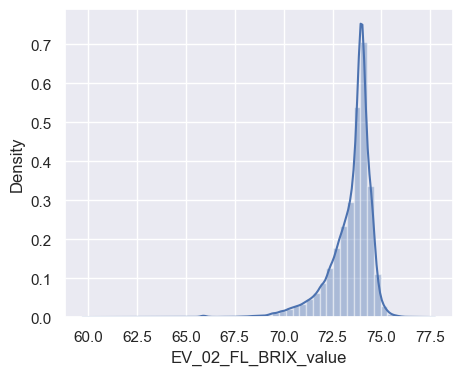

In [14]:
plt.figure(figsize=(5,4))
plt.grid(True)
#sns.distplot(df_FL_Final['Root.정당.MVR 공정.농축관1탑.EV_01_STEAM_FLOW'])
#plt.show()
#sns.distplot(df_FL_Final['FL TK P/P유량'])
#plt.show()
#sns.distplot(df_FL_Final['Root.정당.MVR 공정.농축관2탑.EV_02_CONDENSER_VACCUM'])
#plt.show()
#sns.distplot(df_FL_Final['Root.정당.농축공정.STEAM.EVA_S/T_F'])
#plt.show()
sns.distplot(df_FL_Final['EV_02_FL_BRIX_value'])
plt.show()

In [15]:
pd.set_option('display.max_rows', None)
display(df_FL_Final.corr()[['EV_02_FL_BRIX_value']].abs().sort_values(by='EV_02_FL_BRIX_value',ascending=False).iloc[1:])
pd.set_option('display.max_rows', 10)

,EV_02_FL_BRIX_value
08BC0103_PV_value,0.445321
EVA1_S/T_F_value,0.304153
FL_TK_P/P_F_value,0.295307
EVA1_PRESS_value,0.251948
EV_02_CONDENSER_VACCUM_value,0.239362
EV_01_LIQUEFIED_RETURN_TEMP_value,0.238122
EV_01_LIQUEFIED_OUT_TEMP_value,0.235789
MAGMA_MINGLER_TEMP_value,0.227227
SATURATOR1_PH_PV_value,0.155025
MOIST,0.129031


#### 5.) MVR공정 FL_BRIX농도 분석
- Tree모델 기반 Point Regression & Quantile Regression

In [16]:
def calculate_coverage(y_true, y_lower, y_upper):
    y_true = np.array(y_true)
    coverage = np.mean((y_true >= y_lower) & (y_true <= y_upper))
    return coverage

def calculate_sharpness(y_lower, y_upper):
    y_lower = np.array(y_lower)
    y_upper = np.array(y_upper)
    sharpness = np.mean(y_upper - y_lower) 
    return sharpness

In [17]:
split = -10000
train_data = df_FL_Final.drop(['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE'],axis=1).reset_index(drop=True)[0:split]
test_data = df_FL_Final.drop(['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE'],axis=1).reset_index(drop=True)[split:]

X_train = train_data.drop('EV_02_FL_BRIX_value',axis=1,inplace=False) # [cols9[:-1]] #
X_test =  test_data.drop('EV_02_FL_BRIX_value',axis=1,inplace=False)  # [cols9[:-1]] #

y_train = train_data['EV_02_FL_BRIX_value']
y_test = test_data['EV_02_FL_BRIX_value']

ml = LGBMRegressor(random_state=2021,verbose=-1) #, LGBMRegressor(random_state=2021), 
ml.fit(X_train,y_train) 
#joblib.dump(ml.fit(X_train,y_train),'pkl/FL_BX_LGBM.pkl')
pred = ml.predict(X_test) 
print(evaluate_regr(pred,y_test))

ml = XGBRegressor(random_state=2021)
ml.fit(X_train,y_train) 
#joblib.dump(ml.fit(X_train,y_train),'pkl/FL_BX_XGB.pkl')
pred = ml.predict(X_test) 
print(evaluate_regr(pred,y_test))

ml = GradientBoostingRegressor(random_state=2021)
ml.fit(X_train,y_train) 
#joblib.dump(ml.fit(X_train,y_train),'pkl/FL_BX_GBM.pkl')
pred = ml.predict(X_test) 
print(evaluate_regr(pred,y_test))

ml = HistGradientBoostingRegressor(random_state=2021)
ml.fit(X_train,y_train) 
#joblib.dump(ml.fit(X_train,y_train),'pkl/FL_BX_HGBM.pkl')
pred = ml.predict(X_test) 
print(evaluate_regr(pred,y_test))

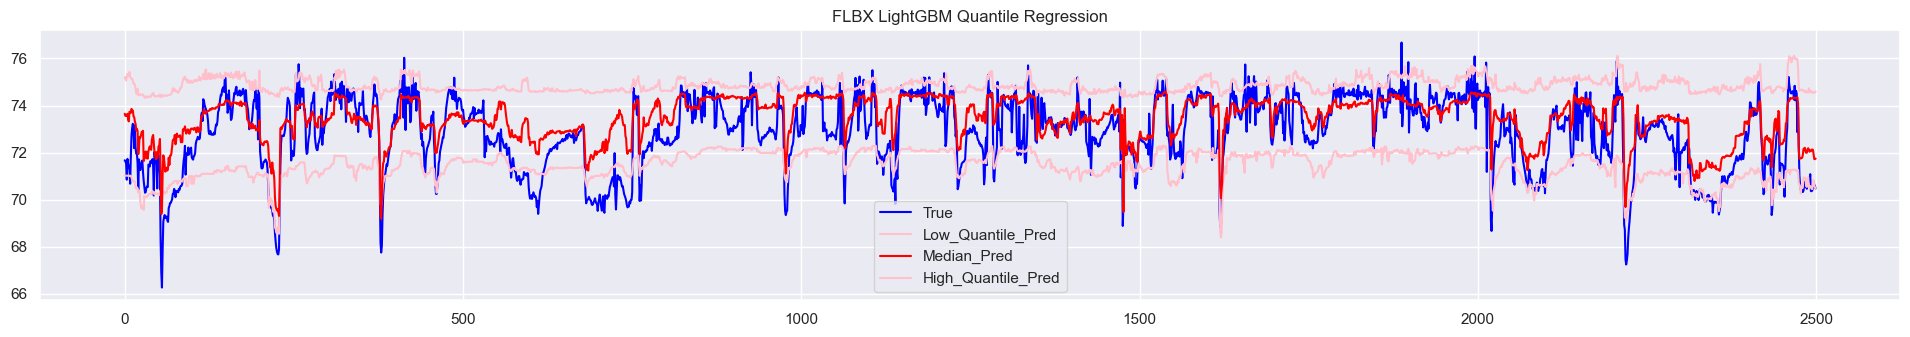

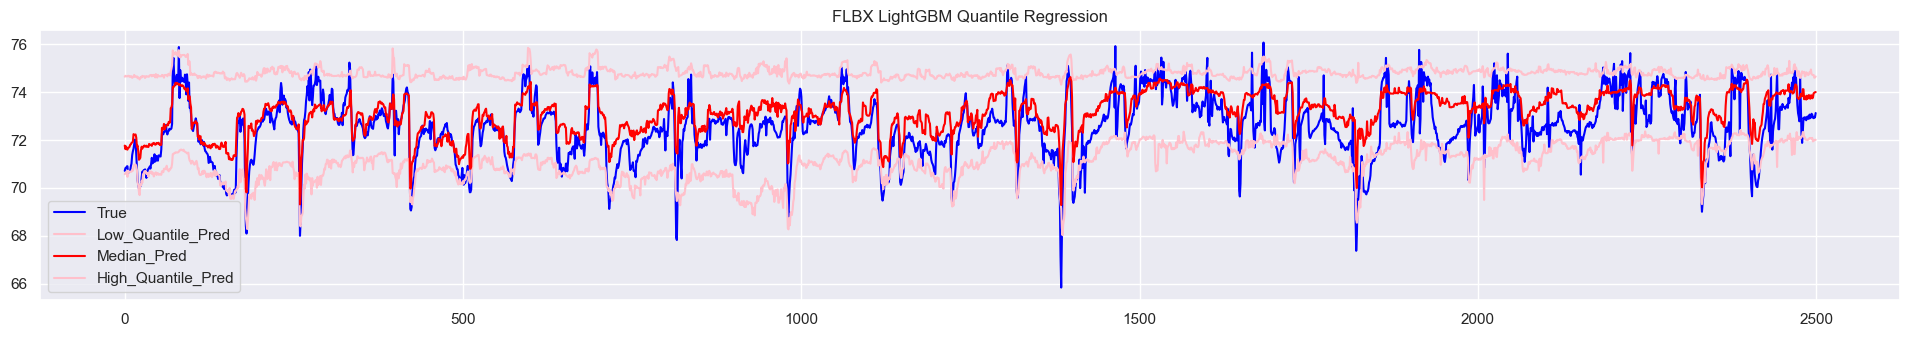

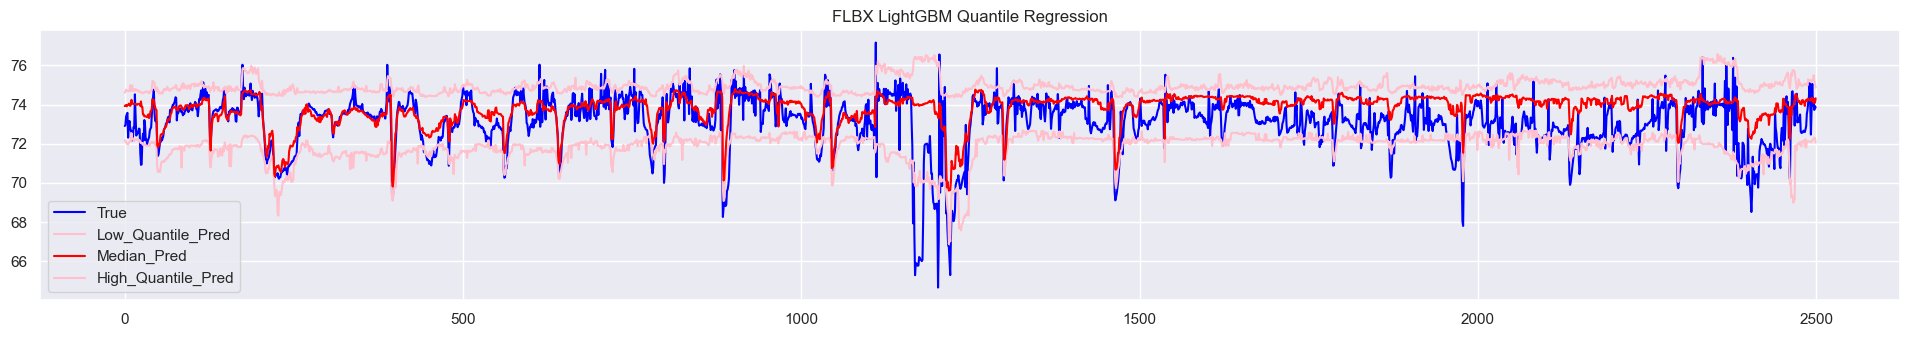

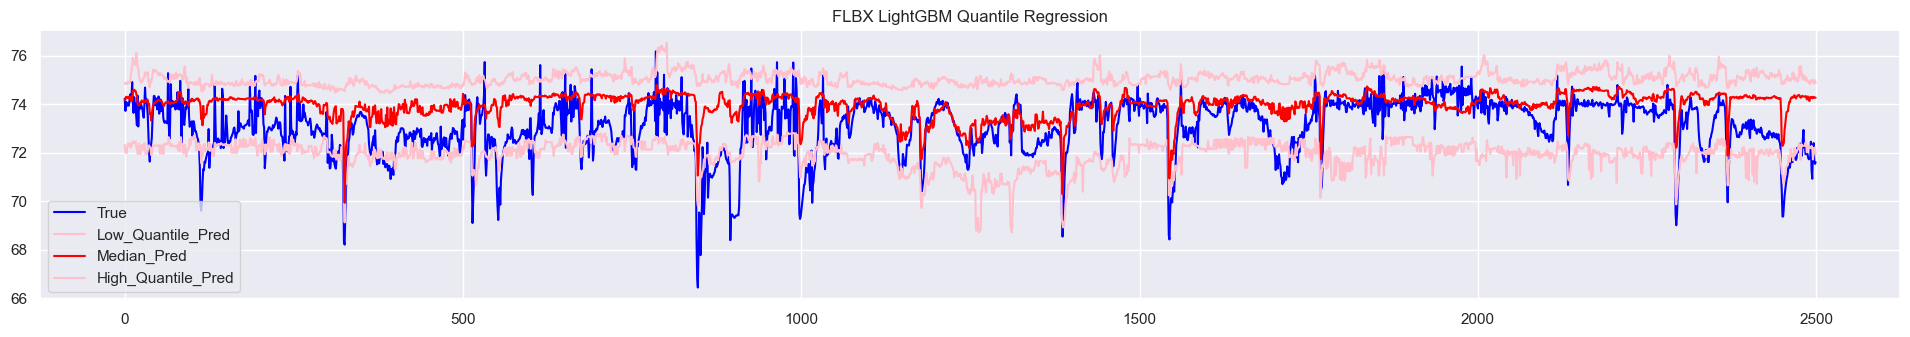

In [18]:
### cv is 1.5%
quantiles = [0.01,0.5,0.99] # min , mean, max
predictions_lgbm = {}
for q in quantiles:
    lgb_model=LGBMRegressor(objective='quantile',alpha=q,random_state=2021,verbose=-1)
    lgb_model.fit(X_train,y_train)
    #joblib.dump(lgb_model.fit(X_train,y_train),'SamYang_API/pkl/FLBX_LGBM_quantile='+str(q)+'.pkl')
    predictions_lgbm[f'LightGBM_Q{int(q*100)}']=lgb_model.predict(X_test)
sns.set(font_scale=1.0)
for i in range(0,len(test_data),2500):
    plt.figure(figsize=(24,3.5))
    plt.title('FLBX LightGBM Quantile Regression')
    plt.plot(y_test.iloc[i:i+2500].reset_index(drop=True),color='blue',label='True')
    plt.plot(pd.DataFrame(predictions_lgbm['LightGBM_Q1']).iloc[i:i+2500].reset_index(drop=True),color='pink',label='Low_Quantile_Pred')
    plt.plot(pd.DataFrame(predictions_lgbm['LightGBM_Q50']).iloc[i:i+2500].reset_index(drop=True),color='red',label='Median_Pred')
    plt.plot(pd.DataFrame(predictions_lgbm['LightGBM_Q99']).iloc[i:i+2500].reset_index(drop=True),color='pink',label='High_Quantile_Pred')
    plt.legend()

#### 6.) MVR공정 FL_BRIX농도 분석
- Bidirectional LSTM
- Monte Carlo Dropout 과적합으로 Uncertainty Interval은 학습데이터의 변동계수 & 추후 실시간 브릭스값들의 표준편차로 정량화 계획 

In [22]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import random
random.seed(1234)
np.random.seed(1234)

def make_sequence_dataset(feature, label, window_size): # (Batch Size, Feature 개수,Time Step)
    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    return np.array(feature_list), np.array(label_list) # 3차원 데이터로 변경 

In [23]:
FL = df_FL
method = 'dl'
df_FL_Final = split_dataset(FL,method)
df_FL_Final.shape

(71322, 37)

In [24]:
df_FL_Final.columns = ['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE',                  
 'MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','MAGMA_MINGLER_TEMP_value','CARORIFIER_S/T_TEMP_value',
 'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value','CO2_GAS_PRESS_value','SATURATOR1_ML_SUPPLY_F_PV_value','SATURATOR1_PH_PV_value',
 'SATURATOR2_ML_SUPPLY_F_PV_value','SATURATOR2_PH_PV_value','FL_TK_BX_PV_value','FL_TK_P/P_F_value','EVA1_S/T_F_value',
 '08BC0103_PV_value','EVA1_PRESS_value','EVA_VACUMM_V/V_PV_value','EVA2_LEVEL_value','EVA2_TEMP_value',
 'EV_01_LIQUEFIED_OUT_TEMP_value','EV_01_LIQUEFIED_RETURN_TEMP_value','EV_01_PL_FLOW_value','08FC0401_PV_value',
 'EV_01_VAPOR_OUT_TEMP_value','EV_01_VAPOR_SEPARATOR_VACCUM_value','EV_02_CONDENSER_VACCUM_value','EV_02_FL_BRIX_value']

In [25]:
pd.set_option('display.max_columns', None)

In [26]:
##### LSTM 데이터 전처리 

df_dl = df_FL_Final#
#df_dl = df_FL_Final.loc[:, ~df_FL_Final.columns.str.contains('원당')]
df_dl = df_FL_Final.drop(['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE'],axis=1)

window_size = 14 # 14

train = df_dl.iloc[:60000]             # Train
val = df_dl.iloc[60000:len(df_dl) - 10000 -window_size]         # Valid
test = df_dl.iloc[len(df_dl) - 10000 -window_size:]             # Test 

from sklearn.preprocessing import MinMaxScaler

scale_cols = df_dl.columns.tolist()
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)

##### Train / Valid / Test Scaling 진행 
feature_train = pd.DataFrame(scaler.transform(train),columns = train.columns)
label_train = feature_train[['EV_02_FL_BRIX_value']]

feature_val = pd.DataFrame(scaler.transform(val),columns = val.columns)
label_val = feature_val[['EV_02_FL_BRIX_value']]

feature_test = pd.DataFrame(scaler.transform(test),columns = test.columns)
label_test = feature_test[['EV_02_FL_BRIX_value']]

feature_train.drop(['EV_02_FL_BRIX_value'],axis=1,inplace=True)
feature_val.drop(['EV_02_FL_BRIX_value'],axis=1,inplace=True)
feature_test.drop(['EV_02_FL_BRIX_value'],axis=1,inplace=True)

#### Train /Valid /Test Numpy 변환 
feature_train_np = feature_train.to_numpy() 
label_train_np = label_train.to_numpy()     

feature_val_np = feature_val.to_numpy()
label_val_np = label_val.to_numpy()     

feature_test_np = feature_test.to_numpy() 
label_test_np = label_test.to_numpy()    


X_train, y_train = make_sequence_dataset(feature_train_np, label_train_np, window_size) 
X_val, y_val = make_sequence_dataset(feature_val_np, label_val_np, window_size) 
X_test, y_test = make_sequence_dataset(feature_test_np, label_test_np, window_size) 

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(59986, 14, 28) (59986, 1)
(1294, 14, 28) (1294, 1)
(10000, 14, 28) (10000, 1)


In [27]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

model=Sequential() # dropout = 0.1 , 0.15 , 0.2
model.add(Bidirectional(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]),recurrent_dropout=0.15,activation='tanh',return_sequences=True)))
model.add(Bidirectional(LSTM(32,activation='tanh',recurrent_dropout=0.15,return_sequences=False)))
model.add(Dense(8, activation='tanh')) # 8
model.add(Dense(1, activation='tanh')) 
model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=200, batch_size=50,callbacks=EarlyStopping(patience=5))
model.summary()

prediction = model.predict(X_test)
prediction_copies_array = np.repeat(prediction,X_train.shape[2]+1, axis=-1)
pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),X_train.shape[2]+1)))[:,-1]  
true = test.iloc[window_size:]['EV_02_FL_BRIX_value'].reset_index(drop=True)
print(evaluate_regr(pred,true))

Epoch 1/200
1200/1200 [==============================] - 33s 21ms/step - loss: 0.0085 - mae: 0.0628 - val_loss: 0.0365 - val_mae: 0.1680
Epoch 2/200
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0051 - mae: 0.0494 - val_loss: 0.0379 - val_mae: 0.1730
Epoch 3/200
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0044 - mae: 0.0467 - val_loss: 0.0070 - val_mae: 0.0670
Epoch 4/200
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0040 - mae: 0.0445 - val_loss: 0.0080 - val_mae: 0.0720
Epoch 5/200
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0037 - mae: 0.0434 - val_loss: 0.0099 - val_mae: 0.0799
Epoch 6/200
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0035 - mae: 0.0421 - val_loss: 0.0097 - val_mae: 0.0785
Epoch 7/200
1200/1200 [==============================] - 25s 21ms/step - loss: 0.0034 - mae: 0.0413 - val_loss: 0.0130 - val_mae: 0.0926
Epoch 8/200
1200/1200 [==================

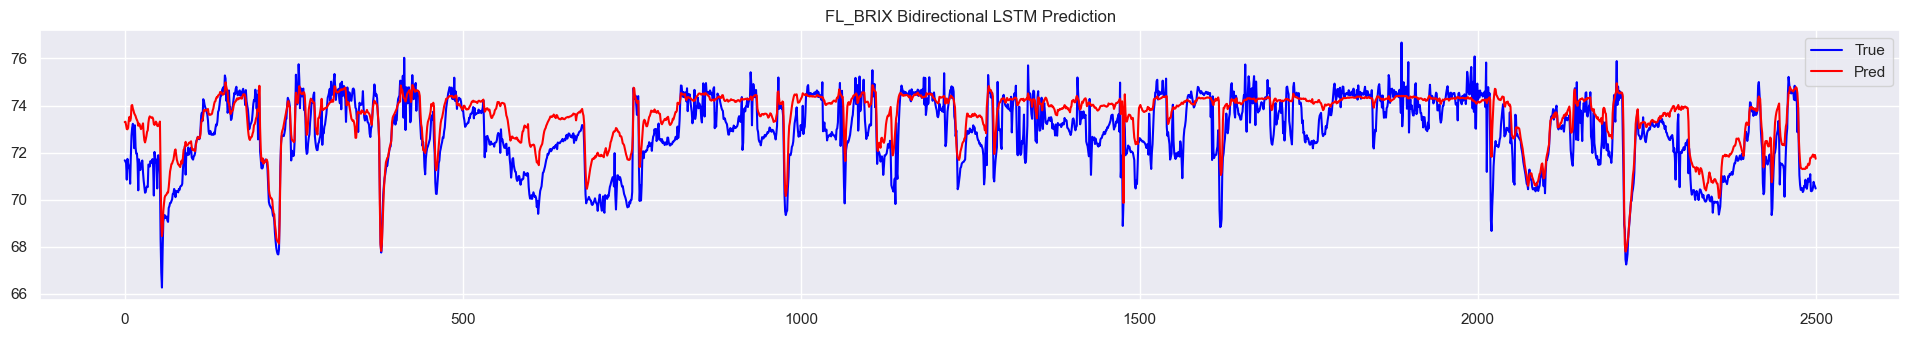

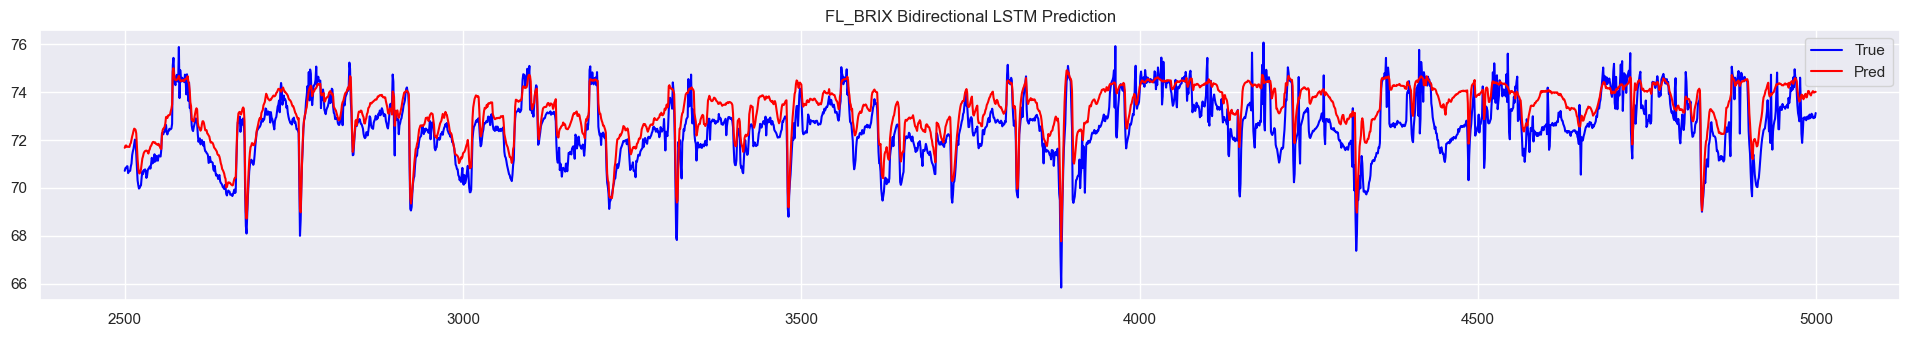

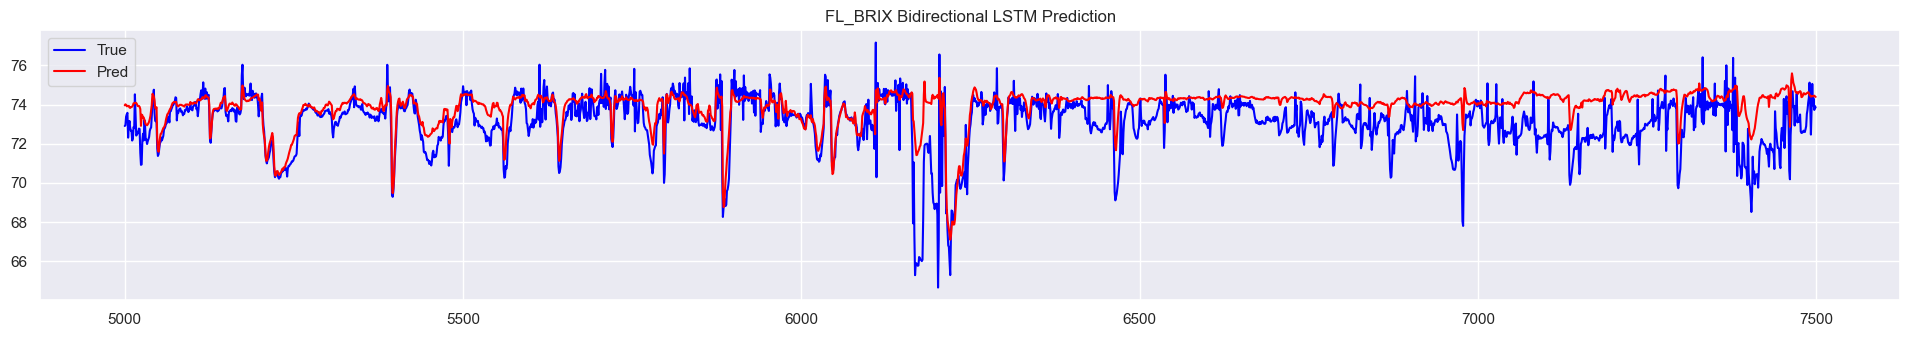

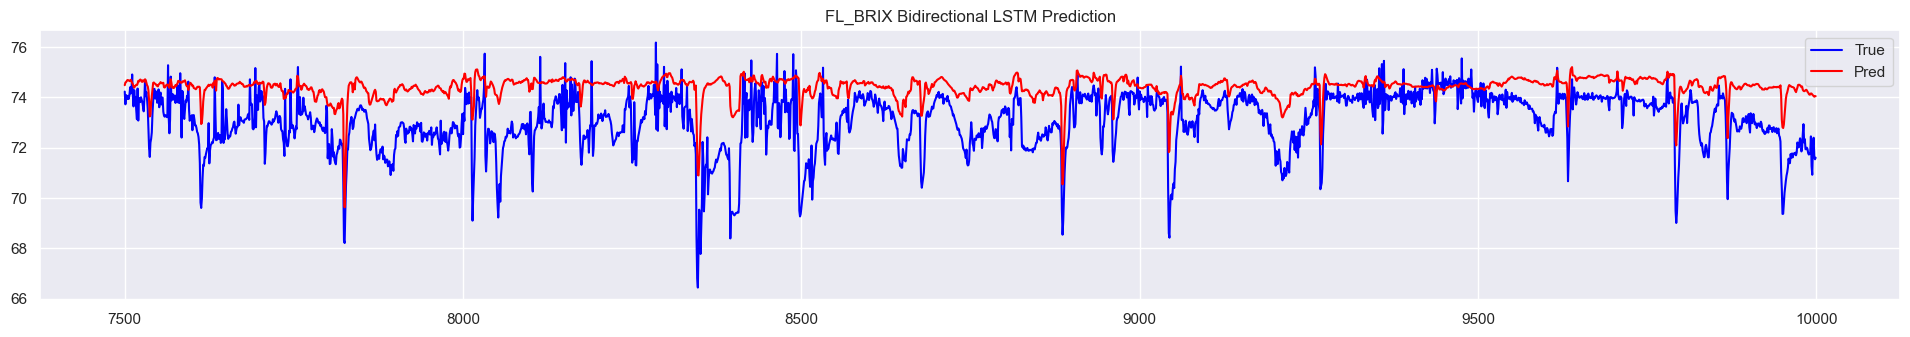

In [28]:
for i in range(0,len(test_data),2500):
    plt.figure(figsize=(24,3.5))
    plt.title('FL_BRIX Bidirectional LSTM Prediction')
    plt.plot(true.iloc[i:i+2500],color='blue',label='True')
    plt.plot(pd.DataFrame(pred).iloc[i:i+2500],color='red',label='Pred')
    plt.legend()